In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow import keras

import os
from bs4 import BeautifulSoup

## Loading and preprocessing Data

In [62]:
img_folder = './images/'
annot_folder = './annotations/'

### Extracting image name and class from xml file

In [63]:
desc = []
for dirname, _, filenames in os.walk(annot_folder):
    for filename in filenames:
        desc.append(os.path.join(dirname, filename));

In [64]:
img_name,label = [],[]

for d in desc:
    content = []
    n = []

    with open(d, "r") as file:
        content = file.readlines()
    content = "".join(content)
    soup = BeautifulSoup(content,"html.parser")
    file_name = soup.filename.string
    name_tags = soup.find_all("name")
    

    for t in name_tags:
        n.append(t.get_text())
        
    # slecting tag with maximum occurence in an image (If it has multiple tags)
    name = max(set(n), key = n.count)
  
    img_name.append(file_name)
    label.append(name)
 

In [65]:
# One Hot Encoding label data
labels = pd.get_dummies(label)
labels.head()

,mask_weared_incorrect,with_mask,without_mask
0,0,0,1
1,0,0,1
2,1,0,0
3,0,1,0
4,0,1,0


In [66]:
# Our target classes
classes = list(labels.columns)
classes

['mask_weared_incorrect', 'with_mask', 'without_mask']

### Loading Images and converting them to pixel array

In [67]:
data, target = [],[]
img_h, img_w = 256, 256

for i in range(len(img_name)):
    name = img_name[i]
    path = img_folder + name
    
    image = load_img(path, target_size = (img_h, img_w))
    image = img_to_array(image)
    data.append(image)
    target.append(tuple(labels.iloc[i,:]))

In [68]:
# Convering list to array
data=np.array(data,dtype="float32")/255.0
target=np.array(target,dtype="float32")

### Visualizing few images randomly

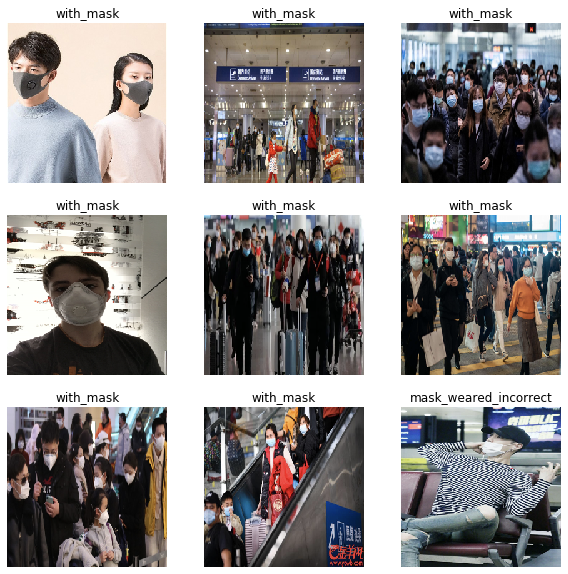

In [69]:
plt.figure(figsize=(10, 10))
for i,j in enumerate(np.random.randint(1, 500, 9, dtype=int)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data[j])
    plt.title(label[j])
    plt.axis("off")

In [70]:
data.shape, target.shape

((853, 256, 256, 3), (853, 3))

In [74]:
# Splitting into train and test data
train_img,test_img,y_train,y_test=train_test_split(data,target,test_size=0.2,random_state=20)

In [75]:
print("Train shapes : ",(train_img.shape, y_train.shape))
print("Test shapes : ",(test_img.shape, y_test.shape))

Train shapes :  ((682, 256, 256, 3), (682, 3))
Test shapes :  ((171, 256, 256, 3), (171, 3))


### Generating and fitting Model

In [76]:
data_augmentation = Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_h, img_w, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1)
  ]
)

In [79]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("face_model.h5",
                                                    save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                      restore_best_weights=True)

In [83]:
num_classes = 3
model = Sequential([
    data_augmentation,
    layers.Conv2D(16, 3,padding = "same",input_shape=(img_h, img_w, 3)) ,
    layers.LeakyReLU(),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3,padding = "same"),
    layers.LeakyReLU(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3,padding = "same"),
    layers.LeakyReLU(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128),
    layers.LeakyReLU(),
    layers.Dense(num_classes,activation = "softmax")
])

In [84]:
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'],
              )

In [85]:
epochs = 1000
history = model.fit(train_img,y_train,
                    validation_data=(test_img,y_test),
                    batch_size=32,
                    epochs=epochs,
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/1000
22/22 [==============================] - 18s 797ms/step - loss: 1.3135 - accuracy: 0.7522 - val_loss: 0.7719 - val_accuracy: 0.7778
Epoch 2/1000
22/22 [==============================] - 16s 739ms/step - loss: 0.6165 - accuracy: 0.8240 - val_loss: 0.6848 - val_accuracy: 0.7778
Epoch 3/1000
22/22 [==============================] - 16s 728ms/step - loss: 0.5329 - accuracy: 0.8196 - val_loss: 0.6495 - val_accuracy: 0.7778
Epoch 4/1000
22/22 [==============================] - 16s 725ms/step - loss: 0.5167 - accuracy: 0.8270 - val_loss: 0.6216 - val_accuracy: 0.7778
Epoch 5/1000
22/22 [==============================] - 17s 768ms/step - loss: 0.5173 - accuracy: 0.8255 - val_loss: 0.6101 - val_accuracy: 0.7778
Epoch 6/1000
22/22 [==============================] - 17s 762ms/step - loss: 0.5138 - accuracy: 0.8240 - val_loss: 0.6211 - val_accuracy: 0.7953
Epoch 7/1000
22/22 [==============================] - 16s 744ms/step - loss: 0.5210 - accuracy: 0.8240 - val_loss: 0.5869 - val_ac

* Final validation loss = 0.5871
* Final validation accuracy = 0.7778

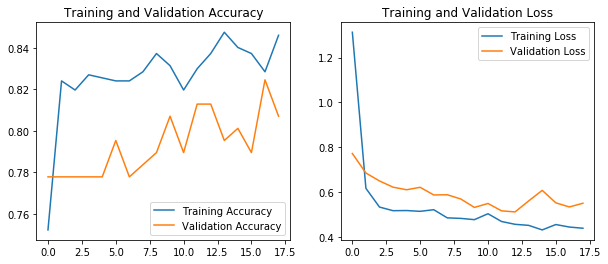

In [99]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Checking predictions

In [100]:
model_to_predict = keras.models.load_model('face_model.h5')

with_mask


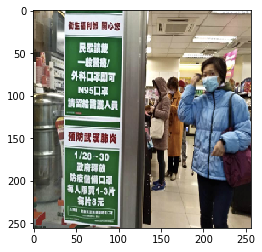

In [101]:
y_pred_1 = model_to_predict.predict(test_img[100].reshape(-1,img_h,img_w,3))
print(classes[np.argmax(y_pred_1)])
plt.imshow(test_img[100])

with_mask


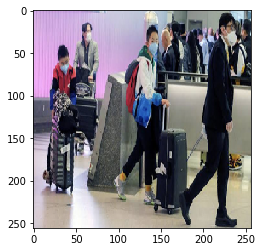

In [102]:
y_pred_2 = model.predict(test_img[3].reshape(-1,img_h,img_w,3))
print(classes[np.argmax(y_pred_2)])
plt.imshow(test_img[3])